# Theft Detection using meter data for Microgrid in Haiti

For our project we have chosen to work with 15 minute resolution data for a microgrid in Haiti.This microgrid is owned & operated by EarthSpark International and the metering infrastructure is provided by SparkMeter who provides the base AMI as well as cloud services like data storage, meter control, automatic billing and grid performance analysis.

The microgrid in Haiti experiences theft owing to the low income demographic in the region. We aim to analyse the data in order to detect theft or non-technical loss and pin point on the theft offenders. 

We've given below a step by step walkthrough of the process utilitzed to detect theft. At the heart of the process we use the concept of correlation to figure out the offenders.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

# Data Load
The Detailed consumption file provides the consumption per customer at the end of a given heartbeat for each subnet. Our first task is to load the two files for detailed consumption and for the losses. We will only foucs on the BC subnet within the dataset. In this segment we noticed that both files have data from the same region but one of the files has a time offset. This offset affects the way the object is converted to the datetime, hence we strip it off the time. 



In [2]:
detailed_consumption = pd.read_csv("LA_detailed_consumption.csv")
detailed_bc = detailed_consumption[detailed_consumption.subnet == 'BC']
detailed_bc.reset_index(inplace = True, drop = True)
detailed_bc.loc[:,'heartbeat_end'] = detailed_bc.loc[:,'heartbeat_end'].apply(lambda x: x.replace('+00:00',''))
detailed_bc.heartbeat_end = pd.to_datetime(detailed_bc.heartbeat_end,infer_datetime_format=True)
detailed_bc.head()

C:\Users\varun\Anaconda3\envs\snakes\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\varun\Anaconda3\envs\snakes\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,serial,heartbeat_end,subnet,kilowatt_hours,true_power_avg
0,SM15R-01-0000028A,2016-04-27 19:30:00,BC,0.000156,0
1,SM15R-01-00000290,2016-04-27 19:30:00,BC,0.000000,0
2,SM15R-01-00000273,2016-04-27 19:30:00,BC,0.000281,0
3,SM15R-01-0000026C,2016-04-27 19:30:00,BC,0.000812,2
4,SM15R-01-00000184,2016-04-27 19:30:00,BC,0.000937,2


Similarly peform the same extraction for the Losses in BC. The losses in BC contains the cumulative readings for all meters/ customers within the subnet at the end of the given heartbeat. The dataset has also been classified into 4 times of hours of day i.e. 
<ol>
<li>
daytime 9-19 
</li>
<li>night_23-6</li>
<li>morning_6-9</li>
<li>evening_19-23</li>
</ol>

In [3]:
losses = pd.read_csv("LA_losses.csv")
losses_bc = losses[losses.subnet =='BC']
losses_bc.heartbeat_end = losses_bc.heartbeat_end.apply(lambda x: x.replace('-05:00',''))
losses_bc.heartbeat_end = pd.to_datetime(losses_bc.heartbeat_end,infer_datetime_format=True)
losses_bc.head()

,heartbeat_end,day,subnet,num_cust,kwh_cust,w_avg_cust,cost,num_cust_off,num_tot,kwh_tot,w_avg_tot,kWh_self_active,kWh_self_inactive,kwh_TL,kwh_NTL,month,period,tod
0,2016-02-04 19:00:00,2016-02-04,BC,101.0,0.233750,830.0,13.122656,14.0,2,0.374750,1496,0.06525,0.0056,0.082537,0.058462,2,-35,evening_19-23
1,2016-02-04 19:15:00,2016-02-04,BC,101.0,0.230719,822.0,13.310156,14.0,2,0.372375,1484,0.06525,0.0056,0.082386,0.059270,2,-35,evening_19-23
2,2016-02-04 19:30:00,2016-02-04,BC,101.0,0.233687,832.0,13.352813,15.0,2,0.373969,1492,0.06450,0.0060,0.082184,0.058097,2,-35,evening_19-23
3,2016-02-04 19:45:00,2016-02-04,BC,101.0,0.231687,820.0,13.248750,15.0,2,0.396719,1582,0.06450,0.0060,0.082084,0.082947,2,-35,evening_19-23
4,2016-02-04 20:00:00,2016-02-04,BC,101.0,0.245031,882.0,13.976719,15.0,2,0.422438,1684,0.06450,0.0060,0.082752,0.094655,2,-35,evening_19-23


We would now like to combine both these data sets to get a holistic view of every individual customers reading against the total consumption and total loss for each heartbeat. Hence we perform an inner join on the heartbeat. We only consider the times when the meter reading was not zero as we suspect that this may be due to an error hence, the 0 reading may act as noise in trying to identify patterns of corelation.

In [4]:
bc_consumption = pd.merge(detailed_bc, losses_bc, how='inner', on = 'heartbeat_end')
bc_consumption = bc_consumption[bc_consumption.kilowatt_hours>0]
print "dataset size:", len(bc_consumption)
bc_consumption.head()

dataset size: 717324


,serial,heartbeat_end,subnet_x,kilowatt_hours,true_power_avg,day,subnet_y,num_cust,kwh_cust,w_avg_cust,...,num_tot,kwh_tot,w_avg_tot,kWh_self_active,kWh_self_inactive,kwh_TL,kwh_NTL,month,period,tod
0,SM15R-01-0000028A,2016-04-27 19:30:00,BC,0.000156,0,2016-04-27,BC,102.0,0.326,1178.0,...,2,0.550156,2198,0.069,0.004,0.0893,0.134856,4,-23,evening_19-23
2,SM15R-01-00000273,2016-04-27 19:30:00,BC,0.000281,0,2016-04-27,BC,102.0,0.326,1178.0,...,2,0.550156,2198,0.069,0.004,0.0893,0.134856,4,-23,evening_19-23
3,SM15R-01-0000026C,2016-04-27 19:30:00,BC,0.000812,2,2016-04-27,BC,102.0,0.326,1178.0,...,2,0.550156,2198,0.069,0.004,0.0893,0.134856,4,-23,evening_19-23
4,SM15R-01-00000184,2016-04-27 19:30:00,BC,0.000937,2,2016-04-27,BC,102.0,0.326,1178.0,...,2,0.550156,2198,0.069,0.004,0.0893,0.134856,4,-23,evening_19-23
7,SM15R-01-00000200,2016-04-27 19:30:00,BC,0.000344,0,2016-04-27,BC,102.0,0.326,1178.0,...,2,0.550156,2198,0.069,0.004,0.0893,0.134856,4,-23,evening_19-23


We would now like to analyze the consumption patterns of each user at a given time of day. We spit the dataset to time of day so we are able to better identify 
<ol>
<li>
Who are likely contenders of causing theft </li>
<li>When does theft occur most</li>
</ol>

In [5]:
bc_consumption.dropna(axis = 0, inplace = True)
grouped_bc = bc_consumption.groupby(['day', 'serial','tod'])

We compute the pearson correlation scores for each group i.e. the individual consumption vs the NTL loss. The idea is to find customers with frequent high negative correlations i.e. 

<ul>
<li>When the NTL loss increases the customers usage decreases, implying they may be stealing at this time.</li>
<li>When the NTL loss decreases the customers usage increases, implying the loss marginally decreases because they stopped stealing.</li>
</ul>

We make sure that we have at least 10 data points so we the method is able to compute a meaningful correlation. We only consider those cases where the p value is less that 0.05. 

In [6]:
dates = []
user = []
score =[]
tod =[]
for name ,group in grouped_bc:
    corr =  stats.pearsonr(group['kwh_NTL'], group['kilowatt_hours'])
    if corr[1] <= 0.05 and len(group)>10:
        dates.append(name[0])
        user.append(name[1])
        score.append(corr[0])
        tod.append(name[2])

This gives us the below set of data points

In [7]:
corr_df = pd.DataFrame(columns = ['user','date','score','tod'])
corr_df['user'] = user
corr_df['date'] = dates
corr_df['score'] = score
corr_df['tod'] = tod


We now have the consumption patters we only consider the negative correlations. We then find the customers who have high repeated cases of negative correlations. 

In [8]:
corr_df = corr_df.sort_values(by= ['date','score'], ascending = [True,True])
corr_n = corr_df[corr_df.score<0]
corr_n.user.value_counts().head(10)



SM15R-01-000001A6    150
SM15R-01-0000031D    101
SM15R-01-000001B2     89
SM15R-01-0000011F     80
SM15R-01-000000C8     76
SM15R-01-000000DD     69
SM15R-01-0000021C     65
SM15R-01-0000020C     65
SM15R-01-0000013F     64
SM15R-01-000001F6     61
Name: user, dtype: int64

In [9]:
top_th = corr_n.user.value_counts()

top5 = []

for i in range(5):
    top5.append(top_th.index[i])

print "Theft counts per time of day:"
temp = corr_n.groupby(['tod'])
print "Count" , "tod"
for name, grp in temp:
    print len(grp) ," ", name
    
corr_night = corr_n[corr_n.tod == 'night_23-6']
corr_night = corr_night[corr_night.score< -0.50]

print "\nTop 10 Offenders at night time:"
print corr_night.user.value_counts()[:10]
# print corr_night[corr_night.user =='SM15R-01-000001A6']
#     print name
# commonDates = []
# for i in range(5):
#      commonDates.extend(list(set(corr_n[corr_n.user ==top5[i]].date)))

# d = {commonDates.count(x):x for x in commonDates}
# print d.values(), d.keys()

# count = 0

# for off in top5:
#     count = count + 1
#     x = bc_consumption[bc_consumption['serial'] == off]
#     x =x[x['day']=='2016-06-11']
#     if count == 3 or count == 4:
#         continue
#     x.kilowatt_hours.plot(x =x.heartbeat_end, label="Kwh", legend=True)
#     x.kwh_NTL.plot(x =x.heartbeat_end,secondary_y=True, label="kwh_NTL", legend=True)
# plt.show()

Theft counts per time of day:
Count tod
856   daytime_9-19
707   evening_19-23
124   morning_6-9
1584   night_23-6

Top 10 Offenders at night time:
SM15R-01-000001A6    59
SM15R-01-000001AD    41
SM15R-01-0000011F    41
SM15R-01-00000196    30
SM15R-01-000001B2    29
SM15R-01-0000020C    29
SM15R-01-000000FE    29
SM15R-01-0000012F    28
SM15R-01-00000113    28
SM15R-01-000002F1    27
Name: user, dtype: int64


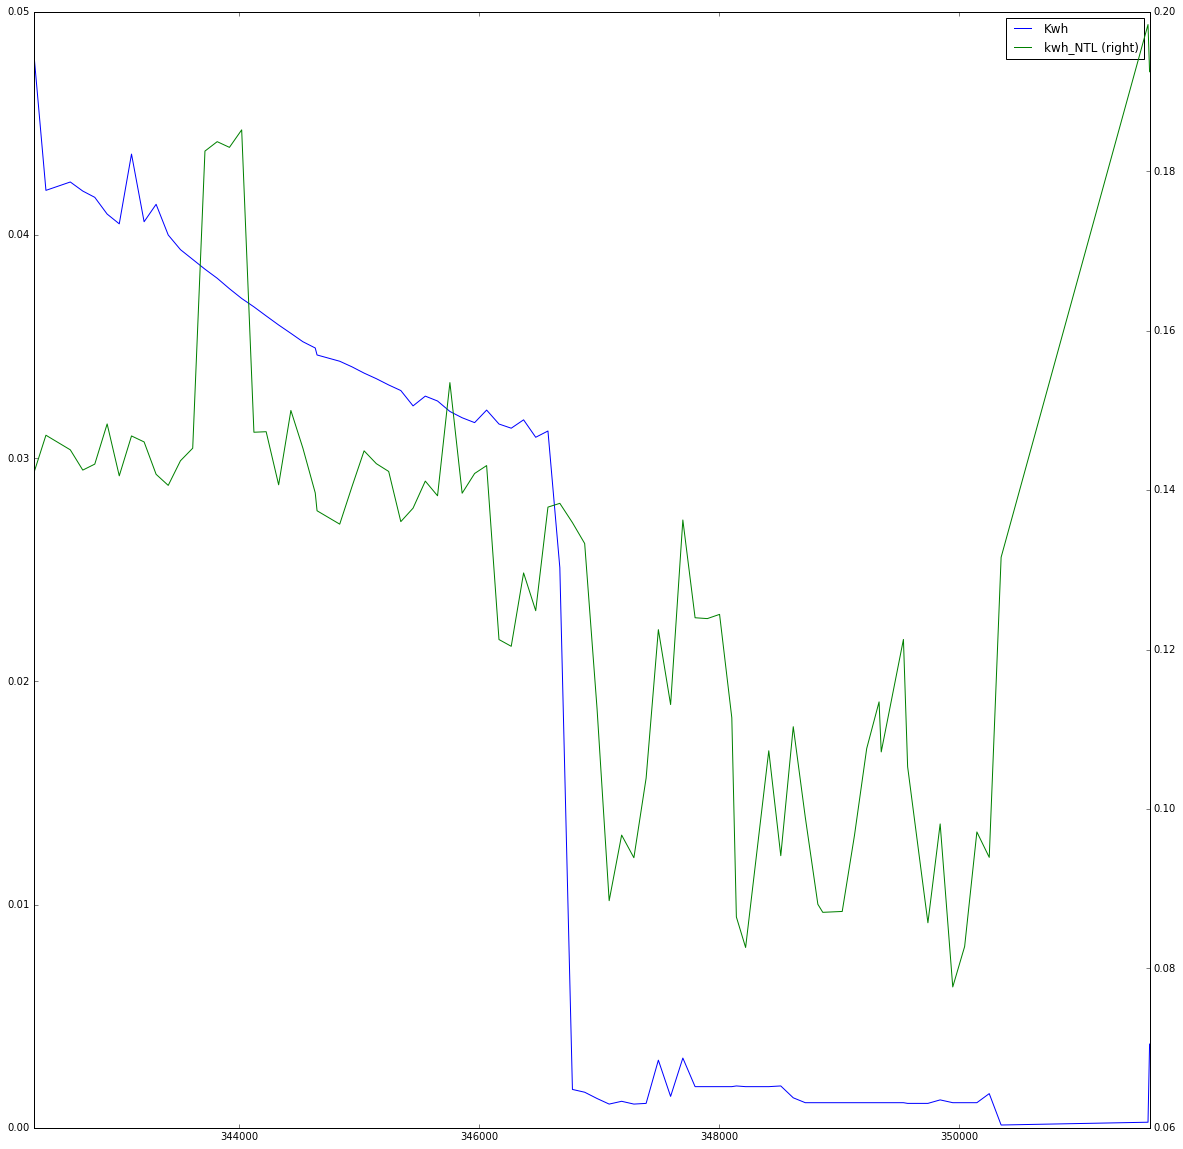

In [10]:
offenderA = bc_consumption[bc_consumption['serial'] == 'SM15R-01-000001A6']
x =offenderA[offenderA['day']=='2016-06-03']
# x = x[x.tod =='night_23-6']
plt.figure(figsize=(20,20))
# print x.heartbeat_end.
x.kilowatt_hours.plot(x =x.heartbeat_end, label="Kwh", legend=True)
x.kwh_NTL.plot(x =x.heartbeat_end,secondary_y=True, label="kwh_NTL", legend=True)
# plt.plot(x.heartbeat_end,x.kilowatt_hours,'r')
# plt.plot(x.heartbeat_end,x.kwh_NTL,'g')
plt.show()
